## Forecasting tasks with USNA $C_n^2$ small dataset

The USNA $C_n^2$ small dataset, described [here](/otb/data/usna_cn2_sm/README.md) in greater detail, allows for the development of short-term $C_n^2$ forecasting models for the near-maritime environment.

This notebook provides an interactive overview of this forecasting task, as well as usage examples to help users build and evaluate their first forecasting models under the `otbench` package.

In [1]:
import sys

sys.path.append('../../')

In [2]:
import pprint

import numpy as np
import lightgbm as lgb

from otbench.tasks import TaskApi
from otbench.plot import plot_predictions

### load the tasks

In [3]:
pprinter = pprint.PrettyPrinter(indent=2, width=100, compact=True)

In [4]:
task_api = TaskApi()

As an illustrative example, we can load the `usna_cn2_sm` forecasting task with missing values removed and develop a new model for predicting optical turbulence strength in the near future from some number of recent optical turbulence and macro-meterological measurements.

In [5]:
task = task_api.get_task("forecasting.usna_cn2_sm.full.Cn2_3m")

The `task` object gives access to the description and associated metadata surrounding the task.

In [6]:
task_info = task.get_info()
pprinter.pprint(task_info)

{ 'description': 'Forecasting task for USNA Cn2 small data, where the last 15 days are set aside '
                 'for evaluation.',
  'description_long': 'This dataset evaluates forecasting approaches for predicting the extent of '
                      'optical turbulence, as measured by Cn2 at an elevation of 3m. Optical '
                      'turbulence on data collected at the United States Naval Academy, across the '
                      'Severn River between Santee Basin and the Waterfront Readiness Center. This '
                      'dataset contains measurements between 01 June 2021 and 31 August 2021, '
                      'inclusive. Meteorological and Oceanographic measurements are collated using '
                      "the scintillometer's internal clock at a 6-minute frequency. Prediction "
                      'accuracy is evaluated  under the root-mean square error metric.',
  'dropna': False,
  'ds_name': 'usna_cn2_sm',
  'eval_metrics': [ 'root_mean_square_

The `forecasting.usna_cn2_sm.full.Cn2_3m` task is a forecasting task which predicts the optical turbulence strength at a height of 3 \[m\] one time step (6 minutes) in the future using the prior 6 time steps (36 minutes) to inform the prediction. Macro-meterological measurements of wind speed, air temperature, water temperature, pressure, and relative humidity are available at training time and form inference.

For this task, the wind direction is assumed as unavailable and is not used for training or during inference. The set of features available is static, however, some measurements contain missing values.

Like the regression tasks, the `train_idx`, `test_idx`, and `val_idx` are fixed. The `train_idx` and `val_idx` attributes specify the indices of the dataset which are available for model development. The `test_idx` attribute specifies the indices of the dataset which are used to evaluate the model during and compare against existing benchmarks for the task.

The task is evaluated using the root mean squared error (RMSE), explained variance score (EVS), mean absolute error (MAE), and mean absolute percentage error (MAPE) metrics. The task is evaluated on the test and validation splits of the dataset, and the training split is used for training new models.

Get the training data

In [7]:
X_train, y_train = task.get_train_data(data_type="pd")

For the forecasting task, we have an additional step in which we prepare the data for forecasting. This involves creating a new column in the dataframe which contains the target variable, adding new columns for lagged featured and targets for each of the 6 prior time steps in the observation window, and shifting the `y_train` data by the forecast horizon.

This is done using the `prepare_data` method of the task object.

In [8]:
X_train, y_train = task.prepare_forecasting_data(X_train, y_train)

Define your model

In [9]:
model = lgb.LGBMRegressor()

Once we have defined the model, we can use the training data provided by the task API (`X_train` and `y_train`).


In [10]:
model.fit(X_train, y_train)

LGBMRegressor()

We can tune hyper parameters using the validation data provided by the task API (`X_val` and `y_val`). In this case, we move directly to evaluation on the test set for our forecasting task.

Evaluate your model

In [11]:
task.evaluate_model(predict_call=model.predict)

{'root_mean_square_error': {'metric_value': 0.16789671817327995,
  'valid_predictions': 4074},
 'coefficient_of_determination': {'metric_value': 0.8683972943955358, 'valid_predictions': 4074},
 'mean_absolute_error': {'metric_value': 0.08689376057499568,
  'valid_predictions': 4074},
 'mean_absolute_percentage_error': {'metric_value': 0.006166048461118418,
  'valid_predictions': 4074}}

Compare against benchmarks

In [12]:
benchmarks = task.get_benchmark_info()

In [13]:
pprinter.pprint(benchmarks)

{ 'ClimatologyForecastingModel': { 'mean_absolute_error': { 'metric_value': 0.38152894906631035,
                                                            'valid_predictions': 4074},
                                   'mean_absolute_percentage_error': { 'metric_value': 0.026964371274693588,
                                                                       'valid_predictions': 4074},
                                   'coefficient_of_determination': { 'metric_value': -0.07556641058405544,
                                                 'valid_predictions': 4074},
                                   'root_mean_square_error': { 'metric_value': 0.4799858269445086,
                                                               'valid_predictions': 4074}},
  'GradientBoostingForecastingModel': { 'mean_absolute_error': { 'metric_value': 0.0815838278224119,
                                                                 'valid_predictions': 4074},
                                      

We can easily access the top two existing models using the `top_models` method of the `task`.

In [14]:
top_2_models = task.top_models(n=2, metric="mean_absolute_percentage_error")

In [15]:
pprinter.pprint(top_2_models)

{ 'GradientBoostingForecastingModel': { 'mean_absolute_error': { 'metric_value': 0.0815838278224119,
                                                                 'valid_predictions': 4074},
                                        'mean_absolute_percentage_error': { 'metric_value': 0.005791995641806741,
                                                                            'valid_predictions': 4074},
                                        'coefficient_of_determination': { 'metric_value': 0.879932260330424,
                                                      'valid_predictions': 4074},
                                        'root_mean_square_error': { 'metric_value': 0.1603699396113978,
                                                                    'valid_predictions': 4074}},
  'lgbm': { 'mean_absolute_error': {'metric_value': 0.08689376057499568, 'valid_predictions': 4074},
            'mean_absolute_percentage_error': { 'metric_value': 0.006166048461118418,
         

Our model performs better than some existing benchmarks, and we can programmatically add it to the `experiments.json` file for future comparison.

In [16]:
_ = task.evaluate_model(
        predict_call=model.predict,
        include_as_benchmark=True,
        model_name="lgbm",
    )

Let's validate that this new model is included in our benchmark results.

In [17]:
top_3_models = task.top_models(n=3, metric="mean_absolute_percentage_error")

In [18]:
pprinter.pprint(top_3_models)

{ 'GradientBoostingForecastingModel': { 'mean_absolute_error': { 'metric_value': 0.0815838278224119,
                                                                 'valid_predictions': 4074},
                                        'mean_absolute_percentage_error': { 'metric_value': 0.005791995641806741,
                                                                            'valid_predictions': 4074},
                                        'coefficient_of_determination': { 'metric_value': 0.879932260330424,
                                                      'valid_predictions': 4074},
                                        'root_mean_square_error': { 'metric_value': 0.1603699396113978,
                                                                    'valid_predictions': 4074}},
  'MeanWindowForecastingModel': { 'mean_absolute_error': { 'metric_value': 0.10216899660692459,
                                                           'valid_predictions': 4074},
             

In addition to computing metrics and comparing with existing benchmarks, the `evaluate_model` method of the `task` can be used to return the model's predictions on the test. This can be used to visualize the model's performance, as well as to investigate trends in prediction error.

In [19]:
_, y_test = task.get_test_data(data_type='pd')
_, y_test = task.prepare_forecasting_data(_, y_test)
_, y_pred = task.evaluate_model(model.predict, return_predictions=True)

We can inspect these predictions visually using the `plot_predictions` method.

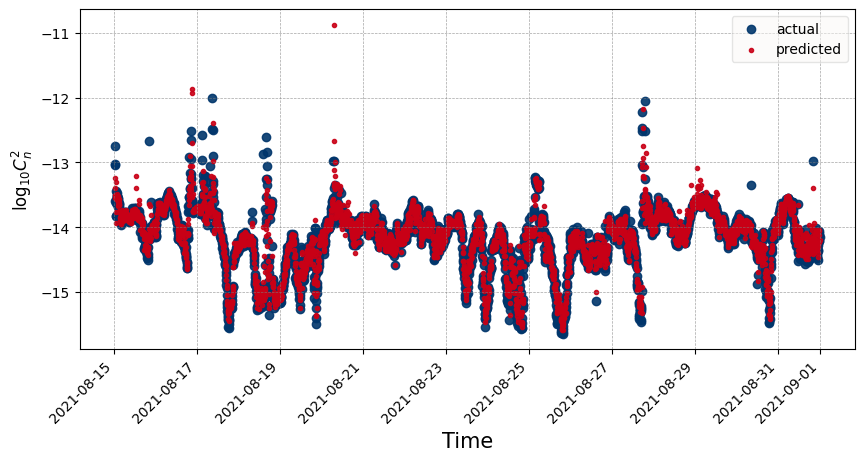

In [20]:
fig, ax = plot_predictions(y_test, y_pred)

The `otb` package includes a baseline forecasting model, the `MeanWindowForecastingModel`, which predicts the strength of optical turbulence at the forecast horizon as the mean of all measurements in the observation window.

This model is reproduced below for reference.

In [21]:
class PersistanceForecastingModel:

    def __init__(
        self,
        name: str,
        target_name: str,
        **kwargs
    ):
        self.name = name
        self.target_name = target_name

    def train(self, X: 'pd.DataFrame', y: 'pd.DataFrame'):
        # maintain the same interface as the other models
        pass

    def predict(self, X: 'pd.DataFrame'):
        """Forecast the cn2 using the mean of the lagged values."""
        # predict the mean for each entry in X
        # X contains some number of lagged values of the target variable
        # we will use the mean of these lagged values as our prediction
        X = X[[c for c in X.columns if c.startswith(self.target_name)]]

        # develop a prediction for each row in X
        preds = []
        for i in range(len(X)):
            # fit a line to the lagged values
            pred = np.mean(X.iloc[i, :].values)
            preds.append(pred)

        return np.array(preds)


Recall that in the forecasting problem, we have access to an observation window with the past 6 time steps (36 minutes) of measurements, and we are tasked with predicting the optical turbulence strength at the forecast horizon (6 minutes in the future).

In [22]:
mean_model = PersistanceForecastingModel(
    name="mean",
    target_name="Cn2_3m",
    )
mean_model.train(X_train, y_train)

We can evaluate the performance of this model using the `evaluate_model` method of the `task`.

In [23]:
task.evaluate_model(mean_model.predict)

{'root_mean_square_error': {'metric_value': 0.1819263113866672,
  'valid_predictions': 4068},
 'coefficient_of_determination': {'metric_value': 0.8456821238656753, 'valid_predictions': 4068},
 'mean_absolute_error': {'metric_value': 0.10204329051598253,
  'valid_predictions': 4068},
 'mean_absolute_percentage_error': {'metric_value': 0.0072238622235996945,
  'valid_predictions': 4068}}

In [24]:
_, y_pred_mean_model = task.evaluate_model(mean_model.predict, return_predictions=True)

We can compare the LightGBM model against the `MeanWindowForecastingModel` model visually using the `plot_predcitions` method. In the resulting plot the `MeanWindowForecastingModel` is labeled as "model 1".

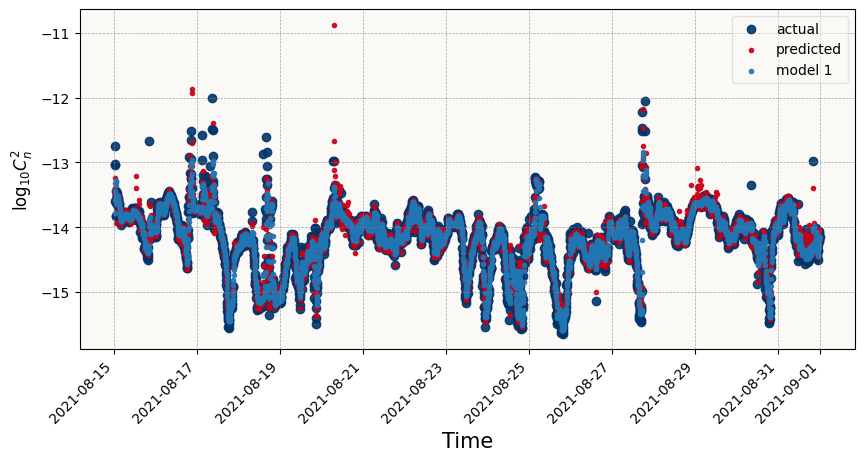

In [25]:
fig, ax = plot_predictions(y_test, y_pred, y_pred_mean_model)

In plotting the predictions of the LightGBM model and the `MeanWindowForecasting` model, we can see that both are able to effectively forecast the strength of optical turbulence. The LightGBM model appears to better capture the dynamics of the optical turbulence strength, while the `MeanWindowForecasting` model appears, unsurprisingly, to tend towards predicting values closer to the mean of the observation window, missing some rapid changes in turbulence strength.